# Deep Learning Project (Master TiCV)

This project was made by Ahmed JARDAK, 

In [27]:
# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

# Keras & Tensorflow
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.utils.vis_utils import plot_model
from transformers import TFAutoModelForSequenceClassification

# Evaluation libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Other Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Disable TensorFlow's warnings and Info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

sns.set_context("notebook", font_scale=1.5)
sns.set_style("whitegrid")

In [3]:
!pip freeze > requirements.txt

## 2. Data Loading

In [4]:
# Reading the dataset with no columns titles and with latin encoding 
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df.columns = ["label", "time", "date", "query", "username", "text"]

# See the first five elements of the dataframe
df.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# We will only be needing the label and text columns, so we will drop the rest.
df = df.drop(["time","date","query","username"],axis=1)

In [6]:
# Convert the 4 values (for positive) to 1, seems more logical
df["label"] = df["label"].replace(4,1) 

# 3. Data Analysis

In [7]:
# Display the dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


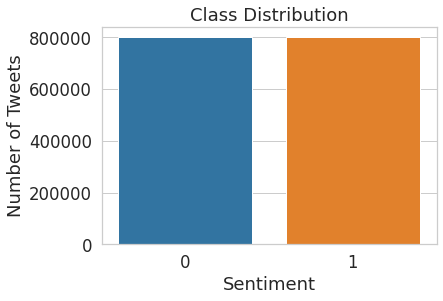

In [8]:
# Count the number of tweets for each sentiment
counts = df["label"].value_counts()

# Create a bar plot of the class distribution
sns.barplot(x=counts.index, y=counts.values)

# Add labels and show the plot
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

Statistics for the text length: 
count    1.600000e+06
mean     1.317615e+01
std      6.957978e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      6.400000e+01
Name: text_length, dtype: float64






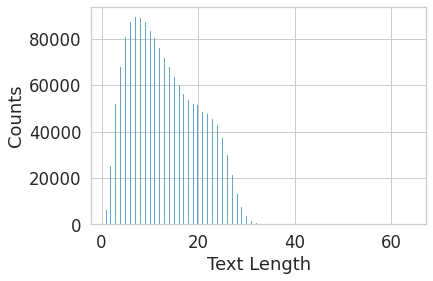

In [9]:
# create a new column to store the text length
df["text_length"] = df["text"].apply(lambda x: len(x.split()))

# use the describe() method to get summary statistics of the text_length column
print("Statistics for the text length: ")
print(df["text_length"].describe())
print("\n\n\n")

# use the histplot() function from the seaborn library to plot a histogram of the text_length column
sns.histplot(df["text_length"])

# add labels to the x-axis and y-axis
plt.xlabel("Text Length")
plt.ylabel("Counts")

# display the plot
plt.show()

Downsampling the data, while keep the same balance (50% - 50%)

In [14]:
#Define downsampling factor
factor = 4

# Count the number of samples of each class in the dataset
num_samples_class_0 = df[df["label"] == 0].shape[0]
num_samples_class_1 = df[df["label"] == 1].shape[0]

# Determine the new number of samples for each class after downsampling
new_num_samples_class_0 = int(num_samples_class_0 / factor)
new_num_samples_class_1 = int(num_samples_class_1 / factor)

# Randomly select the new number of samples for each class from the original dataset
df_class_0_downsampled = df[df["label"] == 0].sample(n=new_num_samples_class_0, random_state=42)
df_class_1_downsampled = df[df["label"] == 1].sample(n=new_num_samples_class_1, random_state=42)

# Concatenate the downsampled dataframes to create the new downsampled dataset
df= pd.concat([df_class_0_downsampled, df_class_1_downsampled])


In [15]:
df.head()
print(df.size)

1200000


# 2. Data Pre-processing

We'll start by creating a function, then applying it on the column containing the tweets, this function is intended to: lower the text, remove mentions and urls as they are irrelevant to the sentiment, remove stopwords, stem the tokens for better model training, and the use of tokenizing.

In [16]:
def text_preprocessing(text):
    # Lowercase the text
    text = text.lower()
    # Remove mentions and urls
    text = re.sub(r"(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(https?:\/\/\S+)","",text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    # Stem the tokens
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(token) for token in tokens]
    # Join the tokens back into a string
    cleaned_text = " ".join(tokens)
    return cleaned_text

In [17]:
df['text_cleaned'] = df['text'].apply(text_preprocessing)

The maximum length for the tweets will be needed for the training later, as the neural network would only validate the input of sequences of the same size, we could pick the highest frequent length but to not lose context we will padd all the sequences to be the same length as the tallest tweet.

In [19]:
max_length = df['text_cleaned'].apply(lambda x: len(x.split())).max()

#Or use our own input sequence length
max_length = 30

We will use the Tokenizer class of Keras, as it offers easy way to transform the texts into sequences for our RNN.

In [20]:
# Create an instance of the Tokenizer class
tokenizer = Tokenizer()

# Fit the tokenizer on the text
tokenizer.fit_on_texts(df['text_cleaned'])

# Convert the text to sequences
text_sequences = tokenizer.texts_to_sequences(df['text_cleaned'])

vocab_size = len(tokenizer.word_index) + 1

In [21]:
text_sequences = pad_sequences(text_sequences, maxlen=max_length)

In [22]:
print("Shape of the sequences array: ",text_sequences.shape)

Shape of the sequences array:  (400000, 30)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(text_sequences, df['label'].values, test_size=0.2,random_state=7)

# 3. Modelling

## 3.1 Training from scratch

In this section, we will try to implement our own implementation of a RNN, favoring the use of LSTM cells as they give outstanding results in Natural Language Processing, beginning with a shallow network to evaluate if the pre-processing we conducted led to an acceptable accuracy.

In [24]:
# Define the model
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 100, input_length=30))
model_1.add(LSTM(32))
model_1.add(Dense(1, activation='sigmoid'))

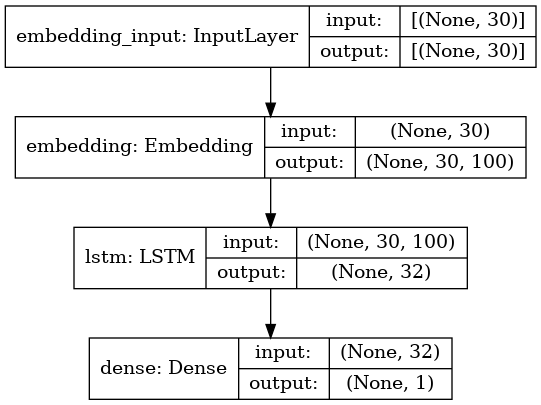

In [25]:
plot_model(model_1, show_shapes=True, show_layer_names=True)

In [26]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test))

Epoch 1/10
625/625 [==============================] - 12s 11ms/step - loss: 0.4985 - accuracy: 0.7592 - val_loss: 0.4734 - val_accuracy: 0.7739
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.4280 - accuracy: 0.8024 - val_loss: 0.4716 - val_accuracy: 0.7762
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3841 - accuracy: 0.8254 - val_loss: 0.4843 - val_accuracy: 0.7720
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3453 - accuracy: 0.8437 - val_loss: 0.5155 - val_accuracy: 0.7696
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3125 - accuracy: 0.8592 - val_loss: 0.5559 - val_accuracy: 0.7645
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.2853 - accuracy: 0.8709 - val_loss: 0.6093 - val_accuracy: 0.7623
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 0.2625 - accuracy: 0.8816 - val_loss: 0.6668 - val_accuracy: 0.760

Our accuracy is getting better, but the validation accuracy seems to stay the same during the epochs, this could be an indicator to overfitting, so we will make a new architecture and add dropout layers to it to prevent the overfitting.

In [29]:
# L2 Regularization
l2_reg = regularizers.l2(0.001)

# Define the model
model_2 = Sequential()
model_2.add(Embedding(vocab_size, 100, input_length=30, activity_regularizer=l2_reg))
model_2.add(LSTM(16, return_sequences=True, activity_regularizer=l2_reg))
model_2.add(Dropout(0.5))
model_2.add(LSTM(8, activity_regularizer=l2_reg))
model_2.add(Dense(32, activation='relu', activity_regularizer=l2_reg))
model_2.add(Dropout(0.4))

# Add a final output layer
model_2.add(Dense(1, activation='sigmoid'))


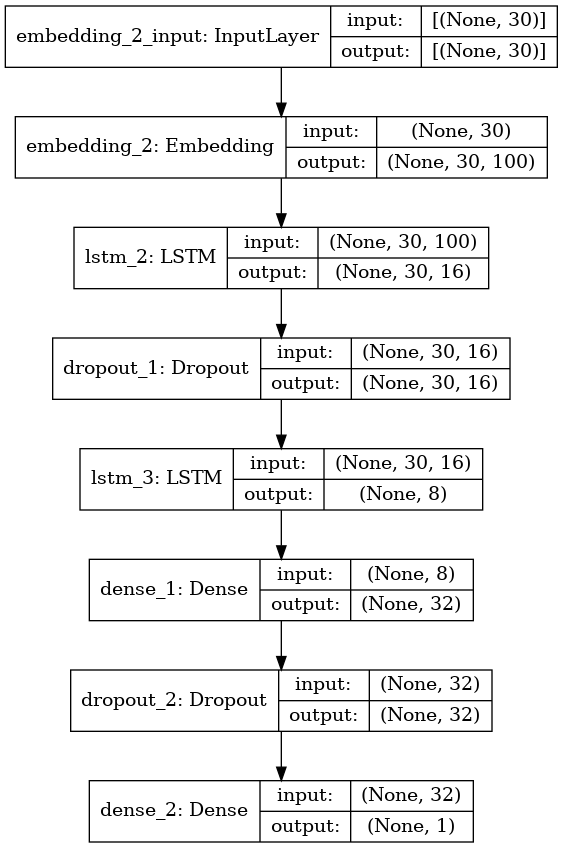

In [30]:
plot_model(model_2, show_shapes=True, show_layer_names=True)

In [32]:
# Compile the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history_2 = model_2.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/5
2500/2500 [==============================] - 34s 12ms/step - loss: 0.4047 - accuracy: 0.8218 - val_loss: 0.5045 - val_accuracy: 0.7688
Epoch 2/5
2500/2500 [==============================] - 30s 12ms/step - loss: 0.3663 - accuracy: 0.8411 - val_loss: 0.5253 - val_accuracy: 0.7635
Epoch 3/5
2500/2500 [==============================] - 30s 12ms/step - loss: 0.3324 - accuracy: 0.8579 - val_loss: 0.5674 - val_accuracy: 0.7635
Epoch 4/5
2500/2500 [==============================] - 30s 12ms/step - loss: 0.3048 - accuracy: 0.8702 - val_loss: 0.6284 - val_accuracy: 0.7569
Epoch 5/5
2500/2500 [==============================] - 30s 12ms/step - loss: 0.2840 - accuracy: 0.8801 - val_loss: 0.6526 - val_accuracy: 0.7578


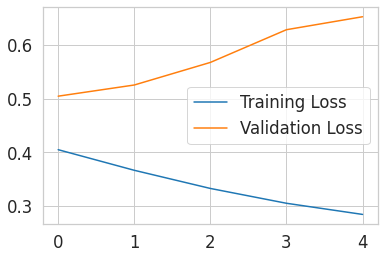

In [33]:
# Plot the training loss and accuracy
plt.figure()
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

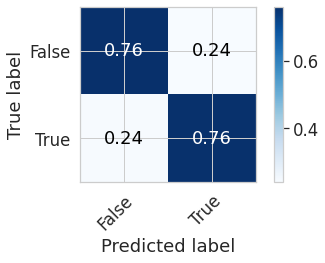

In [34]:
# Generate test set predictions
y_pred = model_2.predict(X_test)

# convert predictions to binary labels
y_pred_binary = np.round(y_pred).ravel()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# plot confusion matrix with rates
fig, ax = plt.subplots()
im = ax.imshow(cm / np.sum(cm, axis=1)[:, np.newaxis], interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['False', 'True'], yticklabels=['False', 'True'],
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j] / np.sum(cm, axis=1)[i], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

## 3.2 Using BERT

In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification

# Load the pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
# Freeze the BERT model to reuse the pretrained features without modifying them
#bert_model.bert.embeddings.word_embeddings.trainable = False

In [ ]:
# Compile the model with a binary crossentropy loss and Adam optimizer
bert_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model on the training data
bert_model.fit(X_train, y_train, epochs=3,batch_size=64, validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model on the test data
bert_model.evaluate(X_test, y_test)